# Turntable, An Artist Reccomendation System Powered by K-Means

This project was developed by Uzay Karadağ, Hakan İşçi and Muhammed Fatih Kaya to be presented as the final project of Intro. to Data Science class given by Prof. Atabey Kaygun at Istanbul Technical University.

---
#### Getting started, the libraries

As all projects developed in the Python ecosystem, this project also relies on the rich and easy-to-use Python modules. We tried to keep the library use in this project minimal and tried to do as much as we can without adding unneccessary code complexity. The **pandas** library was used to present and manipulate the data to our liking. You will notice that the *apply()* method was used heavily for cleaning and further manipulation o the data. Regex was also used briefly to drop punctuation characters from some parts as we learn in the class. matplotlib was used to plot here and there, and finally scikit-learn did the heavy-lifting behind the scenes for us by porviding the K-Means model for our clustering algorithm.

In [40]:
import pandas as pd

import regex as re

from matplotlib import pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#### Acquisition of the data

We run into some problems here and tried several method before settling to this one. As I recall in the first class of the semester Prof. Kaygun, rightfully, told us that local data is not to be trusted. Since we are using a dataset['https://www.kaggle.com/datasets/pieca111/music-artists-popularity'] from Kaggle, first we used Kaggle API to acquire the data however the API seems to be in the beta stage and it can only download the data locally which means it is the same as downloading the data directly to your computer. We also tried the **opendatasets** library and ran into the exact same problem as it is probably just a Python wrapper for the aforementioned Kaggle API. We agreed upon hosting the data as artists.csv inside our Github repo and pushed it using Git LFS.

#### Features of the data, columns

First of all we started inspecting the data by checking what features for every artist we get in this particular dataset. As it turns out a unique id from MusicBrainz database(mbid), artist name, country, tags, listener count data from both MusicBrainz and Last.fm are present. After some exploration we decided to use the artist name corresponding tags and listener count. Tags from MusicBrainz database seemed more reliable as last.fm tags contained too much subjectivity and gibberish at places.

In [41]:
raw = pd.read_csv('artists.csv', low_memory=False)
raw.columns

Index(['mbid', 'artist_mb', 'artist_lastfm', 'country_mb', 'country_lastfm',
       'tags_mb', 'tags_lastfm', 'listeners_lastfm', 'scrobbles_lastfm',
       'ambiguous_artist'],
      dtype='object')

In [42]:
data = pd.DataFrame({'artist': raw['artist_mb'], 'tags': raw['tags_mb'], 'listeners': raw['listeners_lastfm']})
data

,artist,tags,listeners
0,Coldplay,rock; pop; alternative rock; british; uk; brit...,5381567.0
1,Radiohead,rock; electronic; alternative rock; british; g...,4732528.0
2,Red Hot Chili Peppers,rock; alternative rock; 80s; 90s; rap; metal; ...,4620835.0
3,Rihanna,pop; dance; hip hop; reggae; contemporary r b;...,4558193.0
4,Eminem,turkish; rap; american; hip-hop; hip hop; hiph...,4517997.0
...,...,...,...
1466078,정은지,NaN,NaN
1466079,남태현,NaN,NaN
1466080,헤일로,NaN,NaN
1466081,서현진,NaN,NaN


#### Cleaning the data
We then deleted the rows with artist names which are non-latin and streamlined the artist cases to lowercase strings.

In [43]:
data['artist'] = data['artist'].apply(lambda artistName: str(artistName).lower())
data['isAscii'] = data['artist'].apply(lambda artistName: str(artistName).isascii())
data.drop(data[data['isAscii'] == False].index, inplace=True)
data.drop('isAscii', 1, inplace=True)
data

/var/folders/rm/njky_wt54g94lt5wrw23wsg00000gn/T/ipykernel_747/2625950525.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('isAscii', 1, inplace=True)


,artist,tags,listeners
0,coldplay,rock; pop; alternative rock; british; uk; brit...,5381567.0
1,radiohead,rock; electronic; alternative rock; british; g...,4732528.0
2,red hot chili peppers,rock; alternative rock; 80s; 90s; rap; metal; ...,4620835.0
3,rihanna,pop; dance; hip hop; reggae; contemporary r b;...,4558193.0
4,eminem,turkish; rap; american; hip-hop; hip hop; hiph...,4517997.0
...,...,...,...
1466072,misako adjumy sekiguchi,NaN,NaN
1466073,geeks,NaN,NaN
1466074,mino,NaN,NaN
1466075,minho,NaN,NaN


We are going to vectorize the tags and use them as the fitting data for our K-Means model later on so we won't be able to use the artists with no tags therefore we dropped all the NaN rows.

In [44]:
data.dropna(inplace=True)
data

,artist,tags,listeners
0,coldplay,rock; pop; alternative rock; british; uk; brit...,5381567.0
1,radiohead,rock; electronic; alternative rock; british; g...,4732528.0
2,red hot chili peppers,rock; alternative rock; 80s; 90s; rap; metal; ...,4620835.0
3,rihanna,pop; dance; hip hop; reggae; contemporary r b;...,4558193.0
4,eminem,turkish; rap; american; hip-hop; hip hop; hiph...,4517997.0
...,...,...,...
985950,the world heritage,japanese; space rock; avant-prog; likedis auto,0.0
986010,hal from apollo'69,likedis auto,0.0
986061,jaermulk manhattan,likedis auto,0.0
986079,los gatos de japon,likedis auto,0.0


As the final step in our data cleaning process we dropped all artists who have less than 10000 listeners. As much as I am for small artists, their tags are quite horrid to put into a machine learning model therefore it's better to let them go. Then we removed all punctuation from the tag lists such as ';' as our vectorizer won't be liking the use of punctuation. This can be summarized as tokenizing the tags altogether.

In [45]:
data.drop(data[data['listeners'] < 10000.0].index, inplace=True)
tags_new = data['tags'].apply(lambda tagsStr: re.sub(r'[^\w\s]', '', tagsStr))
data['tags'] = tags_new
data

,artist,tags,listeners
0,coldplay,rock pop alternative rock british uk britanniq...,5381567.0
1,radiohead,rock electronic alternative rock british grung...,4732528.0
2,red hot chili peppers,rock alternative rock 80s 90s rap metal americ...,4620835.0
3,rihanna,pop dance hip hop reggae contemporary r b elec...,4558193.0
4,eminem,turkish rap american hiphop hip hop hiphop mid...,4517997.0
...,...,...,...
68696,beastcraft,black metal,10009.0
68697,jaime torres,argentine,10009.0
68718,quatermass,british uk english,10003.0
68726,noitalinna huraa!,rock pop,10002.0


#### Studying the distribution of the number of tags

Out of curiosity I decided to check how the number of tags were distributed among the data for individual artists. It turns out the distribution resembles a chi-square one. I decided drop artists with tag count less than 3 to make the model more accurate.

<AxesSubplot:>

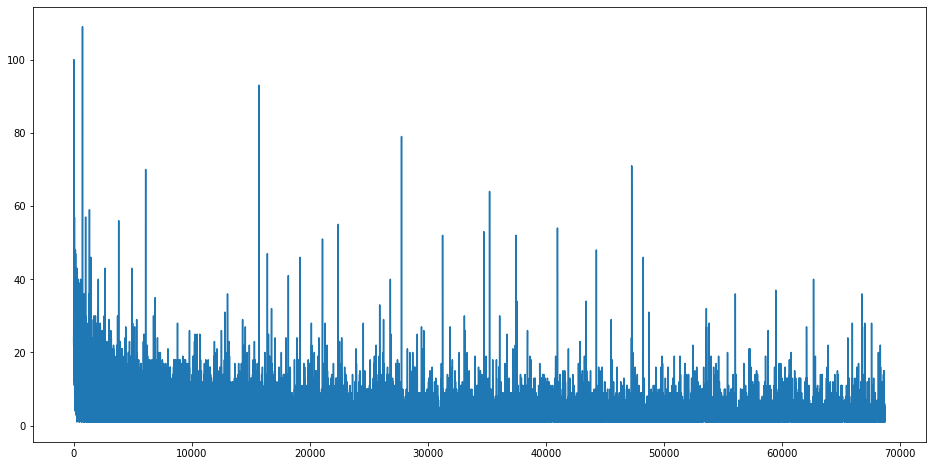

In [46]:
tag_count = data['tags'].apply(lambda tagsStr: tagsStr.count(' ') + 1.0)
tag_count.plot(figsize=[16, 8])

In [47]:
tag_count.mean()

5.0933297228991785

In [48]:
data['tag_count'] = tag_count
data.drop(data[data['tag_count'] < 3].index, inplace=True)
print(data['tag_count'].mean())
data.drop('tag_count', axis=1, inplace=True)

7.2494772514240395


#### The fun part, vectorizing the tags and building the K-Means model
I'm going to be honest I am practically a beginner when it comes to machine learning so this part was mainly built using the age-old trial and error method and I still think anyone who understands machine learning would not be amused by the job I've done. After putting in hours of work and getting too deep I researched better ways to validate if the data was fit for clustering and the result was not really pleasant. The following *k vs Distortion* graph follows a linearly decreasing trend which probably means the tags are not really fit to use for a clustering algorithm. I researched tons of other algorithms and datasets to build a similar project but this was the best pair I could come up with. I hope it is sufficient even though it's not optimal.

I used the TF-IDF vectorizer which is the combination of the CountVectorizer and TF-IDF Transformer, after research and trial this was the vectorizer which birthed the best results.

Then I calculated distortion for all k-values between 1 and 20 even though not perfect k=8 seemed to have a higher slope compared to other k values, so I went with k=8.

I built the 8-means model with max iteration count of 100 and initial n of 10. Then I fit the vectorized tag data to the model and added the output clusters to my dataframe.

In [49]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['tags'])

In [50]:
distortions = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

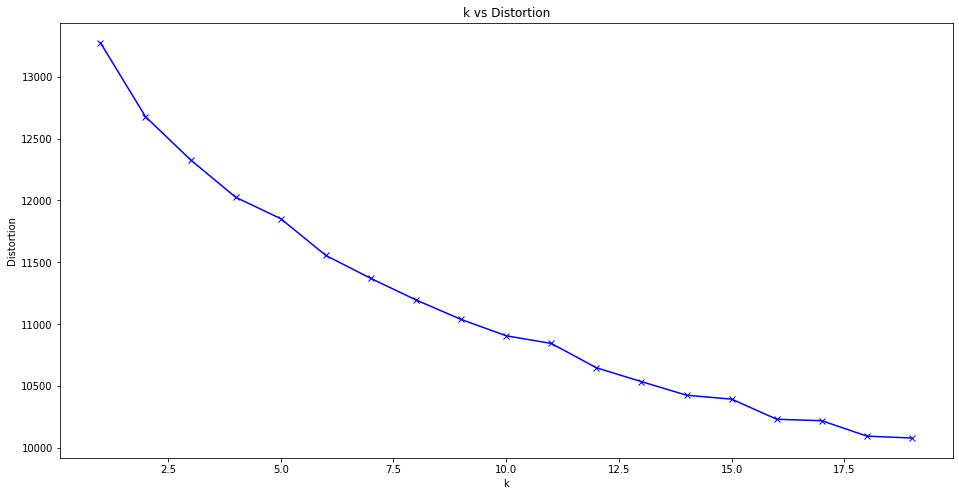

In [51]:
plt.figure(figsize=(16,8))
plt.plot(range(1, 20), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k vs Distortion')
plt.show()

In [52]:
optimal_k = 8
model = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
data['cluster'] = pd.DataFrame(model.labels_)
data.dropna(inplace=True)

In [53]:
data.groupby('cluster').count()

,artist,tags,listeners
cluster,,,
0.0,2702,2702,2702
1.0,491,491,491
2.0,867,867,867
3.0,534,534,534
4.0,422,422,422
5.0,258,258,258
6.0,606,606,606
7.0,437,437,437


#### Final, some artist recommendations from me and the model
Here I wrote a custom function that selects and returns 5 artists from the same cluster with the input artist which have the least amount of difference of listeners with said artist. I tried the function on some of my favorite artists across various genres, the results were quite acceptable.

In [54]:
def recommendArtist(artistName):
    artist = data.loc[data['artist'] == artistName.lower()]
    artist_listeners = artist.listeners.values[0]
    data['listener_diff'] = data['listeners'].apply(lambda count: abs(count - artist_listeners))
    c = artist.cluster.values[0]
    cluster  = data.loc[data['cluster'] == c]
    recDf = cluster.nsmallest(n = 6, columns='listener_diff')[1:6]
    recList = list(recDf['artist'])
    return recList

In [55]:
recommendArtist('aphex twin')

['ice cube',
 'the fratellis',
 'electric light orchestra',
 'lifehouse',
 'garbage']

In [56]:
recommendArtist('kanye west')

['eminem', 'kings of leon', 'david bowie', 'franz ferdinand', 'depeche mode']

In [57]:
recommendArtist('charles mingus')

['carla bruni', 'jason aldean', 'relient k', 'sugar ray', 'sevendust']

In [58]:
recommendArtist('burial')

['everything but the girl',
 'danny elfman',
 'yeasayer',
 'the bangles',
 'johannes brahms']

In [59]:
recommendArtist('madlib')

['the fall', 'darius rucker', 'angie stone', 'saxon', 'beatsteaks']

In [60]:
recommendArtist('radiohead')

['red hot chili peppers', 'the killers', 'nirvana', 'muse', 'coldplay']

In [61]:
from tkinter import *
import tkinter.font as tkFont

tk = Tk()
tk.title("Artist Recommendation System" )
tk.geometry("400x300")

def buton():
        lbl["text"] = f"\n{recommendArtist(entry.get())[0]}\n\n{recommendArtist(entry.get())[1]}\n\n{recommendArtist(entry.get())[2]}\n\n{recommendArtist(entry.get())[3]}\n\n{recommendArtist(entry.get())[4]}\n"

lbl = Label(tk,text="Your Favourite Artist",font=('Times New Roman',15,'bold'),foreground="blue")
lbl.pack()

entry = Entry(tk, width=30)
entry.pack()

btn = Button(tk,
            text="Recommend",
            padx="40",pady="5",
            command=buton)
btn.pack()

lbl = Label(tk)
lbl.pack()

tk.mainloop()

ModuleNotFoundError: No module named '_tkinter'

#### Thank you to Professor Kaygun
Throughout this class I have learned a whole lot about using data in a meaningful way. The selection of data and the questions in the homework's made it a joy to do classwork. There were several moments where I fell back in love with coding while doing the homeworks. Thank you for showing us what it is to be an ITU student.